# **Titanic - Machine Learning from Disaster**


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# Table of Contents

* [1: Modules](#Modules)
* [2: Preparing Data](#PreparingData)
    * [2.1: Read Data](#ReadData)
    * [2.2: Missed Data Status](#MissedDataStatus)
    * [2.3: Data Labeling](#DataLabeling)
    * [2.3: Data Visualization](#DataVisualization)
    * [2.3: Imputer Design](#ImputerDesign)
    * [2.3: Encoder Design](#EncoderDesign)
    * [2.3: Drop Useless Features](#DropUselessFeatures)
* [3: Dimensionality Reduction](#DimensionalityReduction)
    * [3.1: Sensitivity Analysis](#SensitivityAnalysis)
        * [3.2: Decide on effective features](#DecideonEffectiveFeatures)
    * [3.3: UMAP Algorithm](#UMAPAlgorithm)
    
* [4: Machine Learning Design](#MachineLearning)
    * [4.1: Scaling](#Scaling)
    * [4.2: Cross Validation Prediction](#CrossValidationPrediction)
    * [4.3: Tuning Hyper Parameters](#TuningHyperParameters)
    * [4.4: Prediction](#Prediction)
    


<a class="anchor" id="Modules"></a>
### **Modules** 

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
import math
from sklearn import svm, ensemble
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import classification_report
from matplotlib.pyplot import figure
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB,CategoricalNB,BernoulliNB,ComplementNB
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression


### **Preparing Data** 
<a class="anchor" id="PreparingData"></a>



<a class="anchor" id="ReadData"></a>
#### **Read Data** 

In [3]:
# mdata = pd.read_csv('/kaggle/input/titanic/train.csv')
# mdata = pd.read_csv('/content/drive/MyDrive/train.csv')
# tdata = pd.read_csv('/content/drive/MyDrive/test.csv')
mdata = pd.read_csv('E:\\Learnings\\dataScience\\train.csv')
tdata = pd.read_csv('E:\\Learnings\\dataScience\\test.csv')
tdata.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


**bold text**<a class="anchor" id="MissedDataStatus"></a>
#### **Missed Data Status** 

In [4]:
plt.figure(dpi=100)
# sns.heatmap(mdata.isnull(), cmap="Greens")
# plt.xlabel('Feature')
# plt.ylabel('Observation')
mdata.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<Figure size 600x400 with 0 Axes>

In [5]:
# Data Preparation (Integration)
xcol1 = ["Name","Age", "Sex","Embarked", "Pclass","Fare","SibSp","Parch" ]
integ_data = pd.concat([mdata[xcol1],tdata[xcol1]])

<a class="anchor" id="ImputerDesign"></a>
#### **Imputer Design**

In [6]:
Imputer = SimpleImputer(strategy= 'most_frequent', missing_values=np.nan)
# Imputer.fit(mdata[['Age_group']])
# mdata[['Age_group']] = Imputer.transform(mdata[["Age_group"]])
Imputer.fit(mdata[['Embarked']])
mdata[['Embarked']] = Imputer.transform(mdata[["Embarked"]])
# #-----
# Imputer.fit(tdata[['Age_group']])
# tdata[['Age_group']] = Imputer.transform(tdata[["Age_group"]])
# Imputer.fit(tdata[['Embarked']])
# tdata[['Embarked']] = Imputer.transform(tdata[["Embarked"]])
# #-----
# Imputer.fit(integ_data[['Age_group']])
# integ_data[['Age_group']] = Imputer.transform(integ_data[["Age_group"]])
Imputer.fit(integ_data[['Embarked']])
integ_data[['Embarked']] = Imputer.transform(integ_data[["Embarked"]])
# ___________________________________________________________________
# Method 2
mean_age_men=mdata[mdata['Sex']=="male"]['Age'].median()
mean_age_women=mdata[mdata['Sex']=="female"]['Age'].median()
mdata.loc[(mdata.Age.isnull()) & (mdata['Sex']=="female"),'Age']=mean_age_women
mdata.loc[(mdata.Age.isnull()) & (mdata['Sex']=="male"),'Age']=mean_age_men
mean_age_men=tdata[tdata['Sex']=="male"]['Age'].median()
mean_age_women=tdata[tdata['Sex']=="female"]['Age'].median()
tdata.loc[(tdata.Age.isnull()) & (tdata['Sex']=="female"),'Age']=mean_age_women
tdata.loc[(tdata.Age.isnull()) & (tdata['Sex']=="male"),'Age']=mean_age_men

<a class="anchor" id="DataLabeling"></a>
#### **Data Labeling**

In [7]:
def data_cleaner(data):
    data["Title"] = data["Name"].apply(lambda x: x[x.find(',') : x.find('.')][1:].strip())
    data["Title"] = data["Title"].apply(lambda x: 'Mr' if x == 'Mr' else x) # Mr
    data["Title"] = data["Title"].apply(lambda x: 'Miss' if x == 'Ms'or x == 'Mme' or x=='Mlle' else x) #Miss
    data["Title"] = data["Title"].apply(lambda x: 'Mrs' if x == 'Mrs' else x) #Mrs
    data["Title"] = data["Title"].apply(lambda x: 'Master' if x == 'Master' else x) #Master
    data["Title"] = data["Title"].apply(lambda x: 'Others' if x != 'Mr' and x != 'Miss' and x!= 'Mrs' and x!= 'Master' else x)

    data["Age_group"] = data["Age"].apply( lambda x: 'KIDs' if math.isnan(x)==False and x<=16 else x)
    data["Age_group"] = data["Age_group"].apply( lambda x: 'TEENs' if (type(x) != str and math.isnan(x) == False and x<=32 and x >16) else x)
    data["Age_group"] = data["Age_group"].apply( lambda x: 'YOUNGs' if (type(x) != str and math.isnan(x) == False and x<=48 and x >32) else x)
    data["Age_group"] = data["Age_group"].apply( lambda x: 'ADULTS' if (type(x) != str and math.isnan(x) == False and x<=64 and x >48) else x)
    data["Age_group"] = data["Age_group"].apply( lambda x: 'OLDs' if (type(x) != str and math.isnan(x)==False and x >64) else x)
    
    data["FamSize"] = data["SibSp"]+data["Parch"]+1
    data["IsAlone"] = 0
    data.loc[data["FamSize"] == 1, 'IsAlone'] = 1
    data["FamSizeLabel"] = data["FamSize"].apply( lambda x: 'Small' if int(x)<=2 else 'Large')

    data["FareInter"] = data["Fare"].apply(   
        lambda x: 'LowFare' if x<=130 else ('MidFar' if float(x)>=130 and float(x)<=256 else ("HighFare" if float(x)>=256 and float(x)<=384 else "ExtraFare"))
        )
    return data

data_cleaner(mdata)
data_cleaner(tdata)
data_cleaner(integ_data)
tdata.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_group,FamSize,IsAlone,FamSizeLabel,FareInter
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,YOUNGs,1,1,Small,LowFare
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs,YOUNGs,2,0,Small,LowFare
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,ADULTS,1,1,Small,LowFare
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,TEENs,1,1,Small,LowFare
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs,TEENs,3,0,Large,LowFare


<a class="anchor" id="DataVisualization"></a>
#### **Data Visualization**

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           687
Embarked          0
Title             0
Age_group         0
FamSize           0
IsAlone           0
FamSizeLabel      0
FareInter         0
dtype: int64

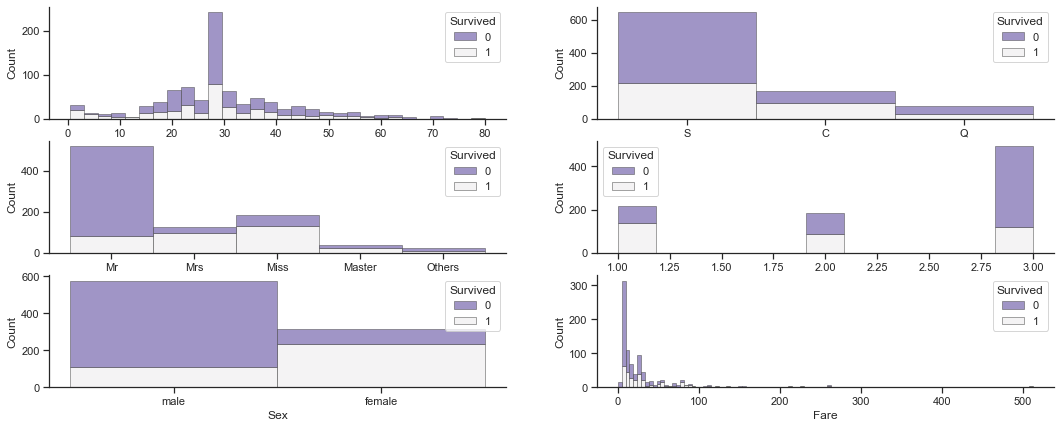

In [8]:
xcol = ["Age","Title", "Sex","Embarked", "Pclass","Fare" ]
huecol = "Survived"
r = 3
c = 2
def mybar(data, xcol, huecol, r, c):
    i = -1
    sns.set_theme(style="ticks")
    f, ax = plt.subplots(r,c,figsize=(18, 7))
    sns.despine(f)
    for col in xcol:
        i+=1
        y = lambda y: int(0) if y<3 else int(1)
        x = lambda x: x if x<3 else int(x-3)
        sns.histplot( data, x=col, hue=huecol, multiple="stack", palette="light:m_r",
            edgecolor=".3", linewidth=.5, log_scale=False,ax = ax[x(i), y(i)])
mybar(mdata, xcol, huecol, r, c)
mdata.isnull().sum()

<a class="anchor" id="EncoderDesign"></a>
#### **Encoder Design**

In [9]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

def titanic_encoder(data):
    enc.fit(data[["Embarked"]])
    data[["S","C","Q"]] = \
        pd.DataFrame(enc.transform(data[["Embarked"]]).toarray())
    #----
    enc.fit(data[["Sex"]])
    data[["F","M"]] = \
        pd.DataFrame(enc.transform(data[["Sex"]]).toarray())
    #----
    #----
    enc.fit(data[["Age_group"]])
    data[["Age1","Age2","Age3","Age4"]] = \
        pd.DataFrame(enc.transform(data[["Age_group"]]).toarray())
    #----
    enc.fit(mdata[["FamSizeLabel"]])
    data[["Small","Large"]] = \
        pd.DataFrame(enc.transform(data[["FamSizeLabel"]]).toarray())
    #----
    enc.fit(mdata[["Pclass"]])
    data[["C1","C2","C3"]] = \
        pd.DataFrame(enc.transform(data[["Pclass"]]).toarray())
    #----
    enc.fit(mdata[["FareInter"]])
    data[["F1","F2","F3"]] = \
        pd.DataFrame(enc.transform(data[["FareInter"]]).toarray())
    return data
def map_encoder(data):
    data['Sex'] = data['Sex'].map( {'female':1,'male':0}).astype(int)
    data['Embarked'] = data['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)
    data["FareInter"] = data["FareInter"].map({'LowFare':0,'MidFar':1,'HighFare':2,'ExtraFare':3,}).astype(int)
    data["Age_group"] = data["Age_group"].map({'KIDs':0,'TEENs':1,'YOUNGs':2,'ADULTS':3,'OLDs':3,}).astype(int)
    data["Title"] = data["Title"].map({'Mr':0,'Miss':1,'Mrs':2,'Master':3,'Others':3,}).astype(int)
    data["Pclass"] = data["Pclass"].astype(int)

    return data
enc_mdata = map_encoder(mdata)
enc_tdata = map_encoder(tdata)
# enc_integ_data = map_encoder(integ_data)

In [10]:
enc_tdata.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_group,FamSize,IsAlone,FamSizeLabel,FareInter
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,2,0,2,1,1,Small,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,0,2,2,2,0,Small,0
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,2,0,3,1,1,Small,0
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,0,0,1,1,1,Small,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,0,2,1,3,0,Large,0


<a class="anchor" id="DropUselessFeatures"></a>
#### **Drop Useless Features**
There are some useless columns like "Name", "Cabin" that their information does not contribute in making a model.
Moreover those columns whose data are encoded to binaries are also removed. Because I am going to work with the binary data.

In [11]:
# col = ["Age","PassengerId","Sex","Name","Cabin","Ticket","Embarked","Title","FamSize","SibSp","Parch","Age_group","Pclass","FamSizeLabel",'Fare',"FareInter"]
col = ["PassengerId","Name","Cabin","Ticket"]
enc_mdata.drop(col,axis = 1,inplace=True)
col = ["Name","Cabin","Ticket"]
enc_tdata.drop(col,axis = 1,inplace=True)


<a class="anchor" id="DimensionalityReduction"></a>
## **Dimensionality Reduction**

<a class="anchor" id="SensitivityAnalysis"></a>
#### **Sensitivity Analysis**

In [12]:
myheatmap=plt.figure(figsize=(25,8))
# sns.heatmap(enc_mdata.corr(),annot=True)
# plt.title("A",loc='left')
enc_mdata.corr()["Survived"].sort_values(ascending=False)

Survived     1.000000
Sex          0.543351
Title        0.439524
Fare         0.257307
FareInter    0.147466
Embarked     0.106811
Parch        0.081629
FamSize      0.016639
SibSp       -0.035322
Age_group   -0.036177
Age         -0.073296
IsAlone     -0.203367
Pclass      -0.338481
Name: Survived, dtype: float64

<Figure size 1800x576 with 0 Axes>

<a class="anchor" id="DecideonEffectiveFeatures"></a>
#### **Decide on Effective Features**

In [13]:
# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
var_col =  ["Sex","Title","FareInter","Embarked","Parch","FamSize","SibSp","Age_group","IsAlone","Pclass"]
fit_col = "Survived"
fs = SelectKBest(score_func=f_classif, k=9)
print("Data shape before feature selection:")
print(enc_mdata.shape)

# apply feature selection
Selected_train_data = fs.fit_transform(enc_mdata[var_col], enc_mdata[fit_col])
print("Data shape After feature selection:")
print(Selected_train_data.shape)





Data shape before feature selection:
(891, 14)
Data shape After feature selection:
(891, 9)


In [14]:
scaler = MinMaxScaler()
x_std = scaler.fit_transform(Selected_train_data)

<a class="anchor" id="MachineLearning"></a>
## **Machine Learning**

<a class="anchor" id="Scaling"></a>
#### **Split Data**
Note: All features have been encoded between 0 and 1, so the scaling data has not been employed here.

In [15]:
y = enc_mdata[fit_col].values
y=np.reshape(y,(len(y),))
x_train, x_test, y_train, y_test = train_test_split(Selected_train_data, y,
                                                    train_size=0.85,
                                                    random_state=0)

<a class="anchor" id="CrossValidationPrediction"></a>
#### **Cross Validation Prediction**
Note: I am evaluating four different classification mehods.

In [16]:
estimators = [svm.SVC(),
              ensemble.RandomForestClassifier(),
              KNeighborsClassifier(), SGDClassifier(),LogisticRegression()]

for esti in estimators:
    y_pred = cross_val_predict(esti,x_train,y_train,cv=3)
    print(f"\nClassification Report for {esti}:")
    print("Accuracy= ", accuracy_score(y_pred, y_train))
    print(confusion_matrix(y_pred, y_train))
    print(classification_report(y_pred,y_train))
        


Classification Report for SVC():
Accuracy=  0.8282694848084544
[[414  74]
 [ 56 213]]
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       488
           1       0.74      0.79      0.77       269

    accuracy                           0.83       757
   macro avg       0.81      0.82      0.82       757
weighted avg       0.83      0.83      0.83       757


Classification Report for RandomForestClassifier():
Accuracy=  0.8005284015852048
[[413  94]
 [ 57 193]]
              precision    recall  f1-score   support

           0       0.88      0.81      0.85       507
           1       0.67      0.77      0.72       250

    accuracy                           0.80       757
   macro avg       0.78      0.79      0.78       757
weighted avg       0.81      0.80      0.80       757


Classification Report for KNeighborsClassifier():
Accuracy=  0.8150594451783355
[[423  93]
 [ 47 194]]
              precision    recall  f1-score   sup

<a class="anchor" id="TuningHyperParameters"></a>
#### **Tuning Hyper Parameters**

In [17]:
# Parameters of support vector machine

kernel=['rbf','sigmoid']
C= [0.5,1,2,3,5,10,15,50,100,500]
gamma = ['scale', 'auto']
distributions = {
    "kernel": kernel,
    "C": C,
    "gamma" : gamma,
}

iestimator = RandomizedSearchCV(
    svm.SVC(),
    param_distributions=distributions,
    n_iter = 40
)

iestimator_dict = iestimator.fit(x_train,y_train)
best_config= iestimator_dict.best_estimator_
best_y_pred = cross_val_predict(best_config, x_train,y_train, cv=3)
print("Accuracy= ", accuracy_score(best_y_pred, y_train))
print(confusion_matrix(best_y_pred, y_train))
print(classification_report(best_y_pred,y_train))

Accuracy=  0.8282694848084544
[[414  74]
 [ 56 213]]
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       488
           1       0.74      0.79      0.77       269

    accuracy                           0.83       757
   macro avg       0.81      0.82      0.82       757
weighted avg       0.83      0.83      0.83       757



In [18]:
# Parameters of random forest

# n_estimators= [50,100,500]
# criterion = ["gini", "entrop", "log_loss"]
# max_depth = [10,50,100]
# min_samples_split = [5,20]
# min_samples_leaf = [5,20]
# max_features = ["sqrt","log2"]
# distributions = {
#     "n_estimators": n_estimators,
#     "criterion": criterion,
#     "max_depth":max_depth,
#     "min_samples_split" : min_samples_split,
#     "min_samples_leaf"  : min_samples_leaf,
#     "max_features":max_features,
#
# }
#
# iestimator = RandomizedSearchCV(
#     ensemble.RandomForestClassifier(),
#     param_distributions=distributions,
#     n_iter = 30
# )
#
# iestimator_dict = iestimator.fit(x_train,y_train)
# best_config= iestimator_dict.best_estimator_
# best_y_pred = cross_val_predict(best_config, x_train,y_train, cv=3)
# print("Accuracy= ", accuracy_score(best_y_pred, y_train))
# print(confusion_matrix(best_y_pred, y_train))
# print(classification_report(best_y_pred,y_train))

<a class="anchor" id="Prediction"></a>
#### **Prediction**

In [19]:
# tdata_final = pd.DataFrame([tdata['PassengerId'],best_config.predict(enc_tdata[var_col])],index = ['PassengerId','Survived']).T
# tdata_final.to_csv('E:\\Learnings\\dataScience\\result.csv')
